In [112]:
import pandas as pd
import numpy as np
import operator 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [113]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [114]:
print(train.shape,test.shape)

(7613, 5) (3263, 4)


In [115]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


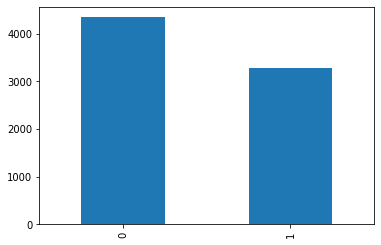

In [116]:
train['target'].value_counts().plot(kind='bar')
plt.show()

In [117]:
train.isnull().sum()/len(train)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

We're missing a negligible amount of keyword tags so we can just drop the rows that are missing that information.

In [118]:
train=train.dropna(subset=['keyword'])

We can drop the locations column altogether

In [119]:
train.drop(columns=['location'],inplace=True)
test.drop(columns=['location'],inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


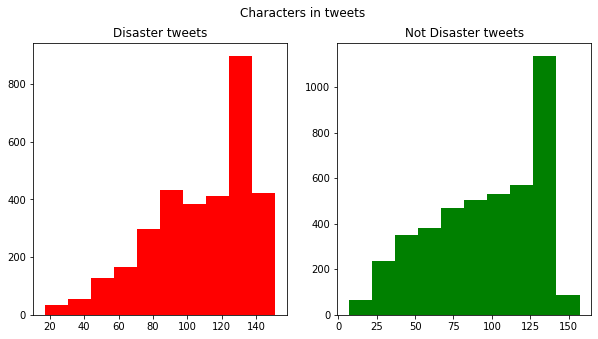

In [120]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not Disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

Not much difference in the average number of characters in a tweet for each class.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


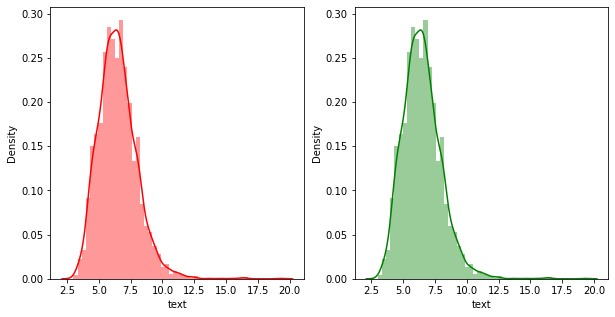

In [121]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
disaster_word_len=train[train['target']==1]['text'].str.split().apply(lambda x:[len(i) for i in x])
sns.distplot(disaster_word_len.map(lambda x:np.mean(x)),ax=ax1,color='red')
regular_word_len=train[train['target']==1]['text'].str.split().apply(lambda x:[len(i) for i in x])
sns.distplot(regular_word_len.map(lambda x:np.mean(x)),ax=ax2,color='green')
plt.show()

Not much difference in the average word length between classes either. 

In [122]:
df=pd.concat([train,test])
df=df.drop(columns=['id'])
df.reset_index(drop=True,inplace=True)
df.head()

,keyword,text,target
0,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
1,ablaze,We always try to bring the heavy. #metal #RT h...,0.0
2,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
3,ablaze,Crying out for more! Set me ablaze,0.0
4,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0.0


Going to try to extract meta-features from the text first

In [123]:
def countChars(text):
  return len(text)
def countWords(text):
  return len(text.split())
def countCapitalWords(text):
  return sum(map(str.isupper,text.split()))
punctuations=string.punctuation[0:2]+string.punctuation[3:]
def countPunctuations(text):
  sum=0
  for s in punctuations:
    sum+=text.count(s)
  return sum
def countHashtags(text):
  return text.count('#')
def countMentions(text):
  x = re.findall(r'(@[A-Za-z0-9]*)', text)
  return len(x)
def countUniqueWords(text):
  return len(set(text.split()))
def countURL(text):
  return len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',text))
df['chars']=df['text'].apply(lambda x:countChars(x))
df['words']=df['text'].apply(lambda x:countWords(x))
df['capitals']=df['text'].apply(lambda x:countCapitalWords(x))
df['punctuations']=df['text'].apply(lambda x:countPunctuations(x))
df['hashtags']=df['text'].apply(lambda x:countHashtags(x))
df['mentions']=df['text'].apply(lambda x:countMentions(x))
df['unique_words']=df['text'].apply(lambda x:countUniqueWords(x))
df['URLs']=df['text'].apply(lambda x:countURL(x))

In [124]:
df.head()

,keyword,text,target,chars,words,capitals,punctuations,hashtags,mentions,unique_words,URLs
0,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0,55,5,0,6,0,1,5,1
1,ablaze,We always try to bring the heavy. #metal #RT h...,0.0,67,10,1,6,2,0,10,1
2,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0,82,9,1,8,1,0,9,1
3,ablaze,Crying out for more! Set me ablaze,0.0,34,7,0,1,0,0,7,0
4,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0.0,76,13,9,5,0,0,13,1


Some light text preprocessing

In [125]:
df['text']=df['text'].apply(lambda x:x.lower())

In [126]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [127]:
contractions_re=re.compile('(%s)' % '|'.join(contraction_mapping.keys()))
def expandContractions(text,contraction_mapping=contraction_mapping):
  def replace(match):
    return contraction_mapping[match.group(0)]
  return contractions_re.sub(replace,text)
df['text']=df['text'].apply(lambda x:expandContractions(x))

In [128]:
def removeURL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
df['text']=df['text'].apply(lambda x:removeURL(x))

In [129]:
def removeHtml(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x:removeHtml(x))

In [130]:
def removeEMOJI(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x:removeEMOJI(x))

Keeping Hashtags since they might contain some keywords that relate to a disaster. 

In [131]:
def removePunctuations(text):
    table=str.maketrans('','',punctuations)
    return text.translate(table)
df['text']=df['text'].apply(lambda x:removePunctuations(x))

Some weird non-UTF-8 characters present

In [132]:
df['text']

0                         bbcmtd wholesale markets ablaze 
1             we always try to bring the heavy #metal #rt 
2        #africanbaze breaking newsnigeria flag set abl...
3                        crying out for more set me ablaze
4        on plus side look at the sky last night it was...
                               ...                        
10810    earthquake safety los angeles ûò safety faste...
10811    storm in ri worse than last hurricane my citya...
10812                    green line derailment in chicago 
10813            meg issues hazardous weather outlook hwo 
10814    #cityofcalgary has activated its municipal eme...
Name: text, Length: 10815, dtype: object

In [133]:
def removeNonUTF8(text):
  return ''.join(x for x in text if x in string.printable)
df['text'].apply(lambda x:removeNonUTF8(x))

0                         bbcmtd wholesale markets ablaze 
1             we always try to bring the heavy #metal #rt 
2        #africanbaze breaking newsnigeria flag set abl...
3                        crying out for more set me ablaze
4        on plus side look at the sky last night it was...
                               ...                        
10810    earthquake safety los angeles  safety fastener...
10811    storm in ri worse than last hurricane my citya...
10812                    green line derailment in chicago 
10813            meg issues hazardous weather outlook hwo 
10814    #cityofcalgary has activated its municipal eme...
Name: text, Length: 10815, dtype: object

In [149]:
processed_train=df[:7552]
processed_test=df[7552:]
processed_test=processed_test.drop(columns=['target'])

In [151]:
processed_train.dropna(subset=['target'],inplace=True)
y=processed_train['target']
X=processed_train[['chars','words','capitals','punctuations','hashtags','mentions','unique_words','URLs']]

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Trying out a basic model on the meta-features

In [26]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=scaler.fit_transform(X)
X

array([[-1.37760281, -1.73795345, -0.46615882, ...,  0.87964546,
        -1.78102954,  0.56934286],
       [-1.02022086, -0.86301015,  0.03347663, ..., -0.50548434,
        -0.83039521,  0.56934286],
       [-0.57349344, -1.03799881,  0.03347663, ..., -0.50548434,
        -1.02052207,  0.56934286],
       ...,
       [-0.24589332, -0.51303283,  0.03347663, ..., -0.50548434,
        -0.45014147,  0.56934286],
       [ 0.08170679, -0.33804417, -0.46615882, ...,  0.87964546,
        -0.2600146 ,  0.56934286],
       [-0.63305709, -0.68802149,  0.03347663, ..., -0.50548434,
        -0.64026834,  0.56934286]])

In [27]:
import sklearn
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y)

In [28]:
from sklearn import svm
model=svm.SVC()
model.fit(X_train,y_train)

SVC()

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score 
y_pred = model.predict(X_val)
accuracy=accuracy_score(y_val,y_pred)*100
cf=confusion_matrix(y_val,y_pred)

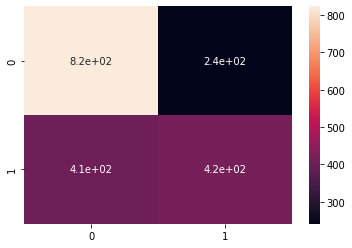

In [30]:
import seaborn as sns
sns.heatmap(cf,annot=True)

In [31]:
accuracy

65.73093220338984

Performance isn't great so we should try to use the actual text instead

In [32]:
!pip install tensorflow-hub
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.5 MB/s eta 0:00:00


In [33]:
X=processed_train.text.astype('string')
y=processed_train.target
X_train,X_val,y_train,y_val=train_test_split(X,y,stratify=processed_train['target'])

In [34]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
preprocessing_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_preprocessing_model=hub.KerasLayer(preprocessing_url)
bert_model=hub.KerasLayer(encoder_url)
input_layer=keras.layers.Input(shape=(),dtype=tf.string,name='input')
preprocessed_text=bert_preprocessing_model(input_layer)
embeddings=bert_model(preprocessed_text)
layer=keras.layers.Dropout(0.1,name='dropout1')(embeddings['pooled_output'])
layer=keras.layers.Dense(10,name='hidden')(layer)
layer=keras.layers.Dropout(0.2,name='dropout2')(layer)
layer=keras.layers.Dense(1,activation='sigmoid',name='output')(layer)
model=keras.Model(inputs=[input_layer],outputs=[layer])
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input[0][0]']                  
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [35]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()])

In [36]:
history=model.fit(X_train, y_train, epochs=5,batch_size=64,validation_data=(X_val,y_val),callbacks=[callback])

Epoch 1/5
89/89 [==============================] - 3430s 38s/step - loss: 0.6485 - binary_accuracy: 0.6395 - precision: 0.5926 - recall: 0.5021 - val_loss: 0.6663 - val_binary_accuracy: 0.6345 - val_precision: 0.8679 - val_recall: 0.1710
Epoch 2/5
89/89 [==============================] - 3394s 38s/step - loss: 0.5788 - binary_accuracy: 0.7085 - precision: 0.6849 - recall: 0.5896 - val_loss: 0.5357 - val_binary_accuracy: 0.7431 - val_precision: 0.7287 - val_recall: 0.6357
Epoch 3/5
89/89 [==============================] - 3407s 38s/step - loss: 0.5552 - binary_accuracy: 0.7274 - precision: 0.7146 - recall: 0.6036 - val_loss: 0.5380 - val_binary_accuracy: 0.7452 - val_precision: 0.6840 - val_recall: 0.7509
Epoch 4/5
89/89 [==============================] - 3399s 38s/step - loss: 0.5500 - binary_accuracy: 0.7345 - precision: 0.7211 - recall: 0.6181 - val_loss: 0.5126 - val_binary_accuracy: 0.7654 - val_precision: 0.7898 - val_recall: 0.6146
Epoch 5/5
89/89 [==============================]

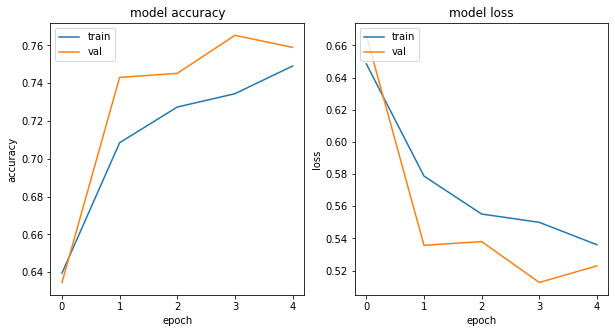

In [45]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history['binary_accuracy'])
ax1.plot(history.history['val_binary_accuracy'])
ax1.title.set_text('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.title.set_text('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
val_predictions=model.predict(X_val)

59/59 [==============================] - 829s 14s/step


In [56]:
val_predictions=np.where(val_predictions.flatten()>0.5,1,0)

0.7590042372881356


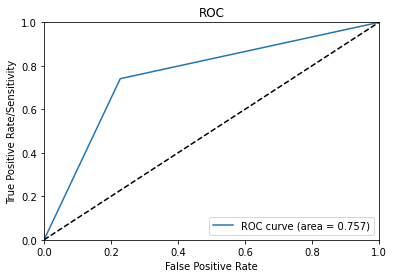

              precision    recall  f1-score   support

not disaster       0.80      0.77      0.79      1081
    disaster       0.71      0.74      0.72       807

    accuracy                           0.76      1888
   macro avg       0.75      0.76      0.76      1888
weighted avg       0.76      0.76      0.76      1888



In [57]:
from sklearn.metrics import accuracy_score,roc_curve, auc, classification_report
print(accuracy_score(y_val, val_predictions))

fpr, tpr, thresholds = roc_curve(np.array(y_val), np.array(val_predictions))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate/Sensitivity')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
print(classification_report(y_val, np.array(val_predictions), target_names=["not disaster", "disaster"]))

In [152]:
X_test=processed_test.text

In [153]:
test_pred = model.predict(X_test)

102/102 [==============================] - 1422s 14s/step


In [154]:
y_predicted=np.where(test_pred.flatten()>0.5,1,0)

In [155]:
y_predicted

array([1, 1, 1, ..., 1, 1, 1])

In [156]:
submission=pd.DataFrame({'id':test['id'].tolist(),'target':y_predicted.tolist()})

In [160]:
submission.to_csv('submission.csv',index=False)

Accuracy improved but definitely not the best (It'll take too long to train a high-quality neural network lmao)